x (300, 2)
t (300, 3)


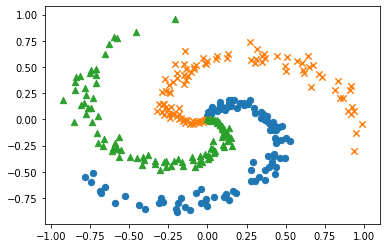

In [7]:
import sys
sys.path.append('..')  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from dataset import spiral
import matplotlib.pyplot as plt


x, t = spiral.load_data()
print('x', x.shape)  # (300, 2)
print('t', t.shape)  # (300, 3)

# 데이터점 플롯
N = 100
CLS_NUM = 3
markers = ['o', 'x', '^']
for i in range(CLS_NUM):
    plt.scatter(x[i*N:(i+1)*N, 0], x[i*N:(i+1)*N, 1], s=40, marker=markers[i])
plt.show()

## Label

In [9]:
print(t[0])
print(t[100])
print(t[200])

[1 0 0]
[0 1 0]
[0 0 1]
